# DDPG on InvertedPendulum

This notebook trains and tests a DDPG agent on the environment Inverted Pendulum. 

## Imports



In [1]:
# specify the path of the repo
%cd /home/arthur/drl/mva-drl-project


from acme import make_environment_spec

from src.environments import InvertedPendulumEnv, inverted_pendulum_env_factory
from src.agents import DDPGAgent
from src.interaction_loops import ddpg_parallel_interaction_loop, ddpg_evaluation_parallel_interaction_loop
from src.replay_buffer import BatchedReplayBuffer
from src.plot_utils import plot_policy_on_pendulum


/home/arthur/drl/mva-drl-project


2022-04-01 16:58:43.888674: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 16:58:43.939174: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 16:58:43.942055: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 16:58:44.499027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
/home/ar

## Environement generation

Here we generate an environment to access the specs. However in the training loop environments will be created in subprocesses.


In [2]:
pendulum_environment = InvertedPendulumEnv(for_evaluation=True)  
pendulum_environment_spec = make_environment_spec(pendulum_environment)


## Agent initialisation

The hyperparameters are the same as in the paper. 

In [14]:
# define the agent
pendulum_agent = DDPGAgent(seed=0, 
                           actor_learning_rate=1e-5,
                           critic_learning_rate=1e-4 , 
                           gamma=.99,
                           environment_spec=pendulum_environment_spec,
                            tau=0.001 #control the slow copy in the targets networks. 
                            )


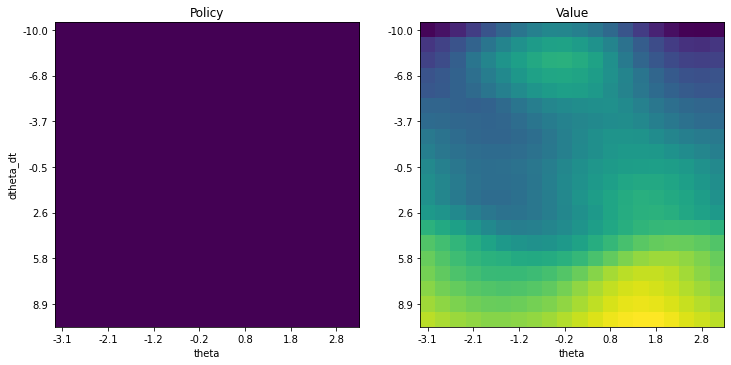

In [15]:
# plot the initial policy and value function

plot_policy_on_pendulum(pendulum_agent, num_bins=20)

## Training

In [17]:
max_learner_steps = int(3e4)
log_returns_every = int(2e3)
replay_buffer = BatchedReplayBuffer(int(2e5))

In [18]:
logs = None
returns = []
return_ts = []

for i in range(max_learner_steps//log_returns_every):
    new_logs, replay_buffer = ddpg_parallel_interaction_loop(pendulum_agent, 
                                      env_factory=inverted_pendulum_env_factory, 
                                      max_learner_steps=log_returns_every,
                                      num_actors=2,
                                      batch_size=64, 
                                      replay=replay_buffer)
    if logs is None:
        logs = new_logs
    else:
        for k,v in logs.items():
            if k =='iterations':
                for it in new_logs[k]:
                    logs[k].append(it+(i*log_returns_every))
            else:
                logs[k] = v + new_logs[k]

    returns.append(ddpg_evaluation_parallel_interaction_loop(pendulum_agent, env_factory=inverted_pendulum_env_factory, sequence_length=200, num_actors=4))
    return_ts.append((i+1)*log_returns_every)    


iteration nb321
actions_mean: 0.52	|bootstrapped_q: 720.62	|done: 0.00	|mean_reward: -0.89	|obs: 0.98	|policy_loss: -1.02	|value_loss: 256739.03	|value_mean: 0.82	|value_target_mean: 712.53
iteration nb641
actions_mean: 0.89	|bootstrapped_q: 265.15	|done: 0.00	|mean_reward: -0.74	|obs: -0.36	|policy_loss: -1.14	|value_loss: 34195.41	|value_mean: 1.02	|value_target_mean: 261.75
iteration nb961
actions_mean: 0.23	|bootstrapped_q: 173.29	|done: 0.00	|mean_reward: -0.96	|obs: -0.35	|policy_loss: -0.29	|value_loss: 14354.37	|value_mean: 1.16	|value_target_mean: 170.59
iteration nb1281
actions_mean: 0.03	|bootstrapped_q: 155.16	|done: 0.00	|mean_reward: -0.81	|obs: 0.89	|policy_loss: -1.87	|value_loss: 11667.28	|value_mean: 1.14	|value_target_mean: 152.79
iteration nb1601
actions_mean: 0.22	|bootstrapped_q: 115.59	|done: 0.03	|mean_reward: -0.95	|obs: -0.34	|policy_loss: -0.40	|value_loss: 6177.57	|value_mean: 0.67	|value_target_mean: 109.91
iteration nb1921
actions_mean: -0.17	|bootstrapped

## Results

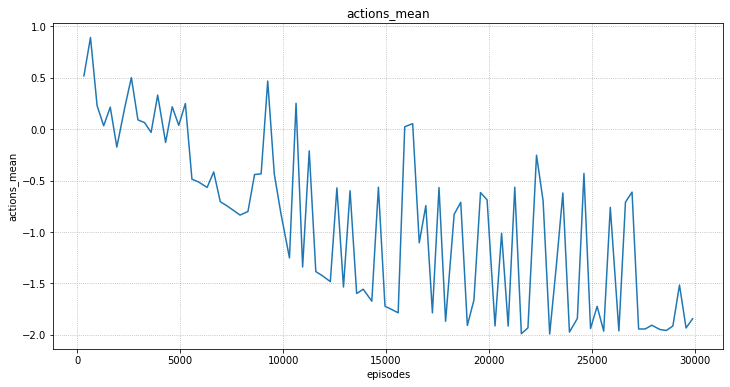

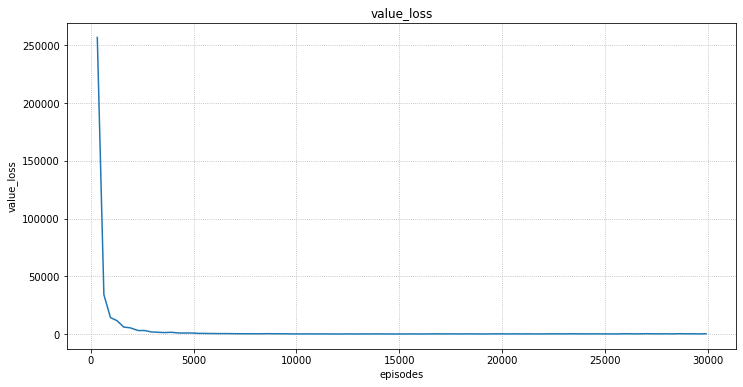

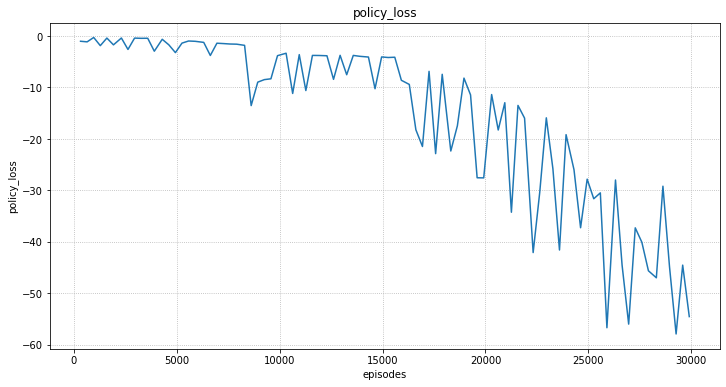

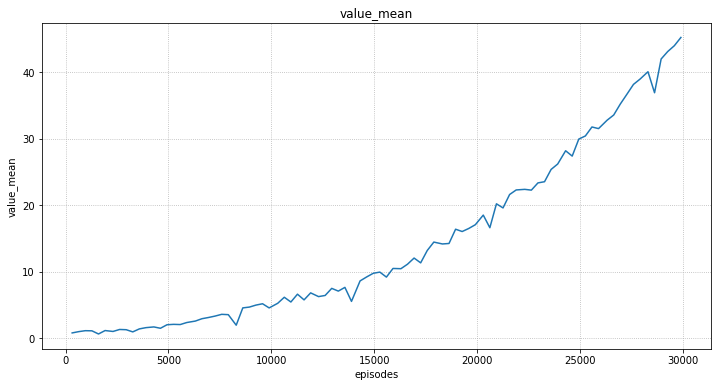

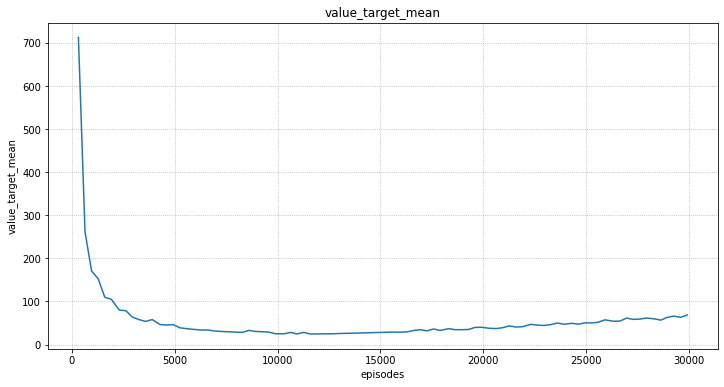

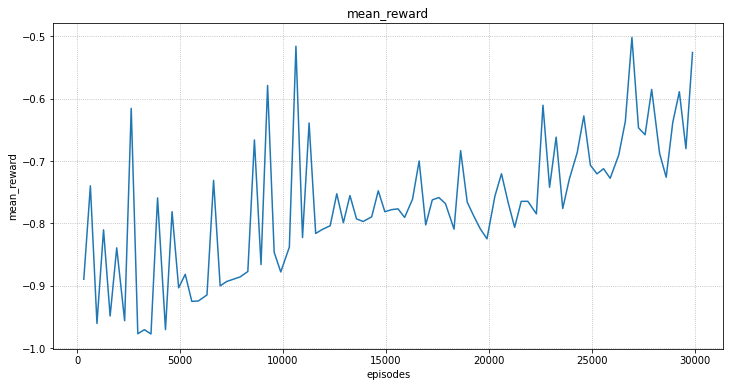

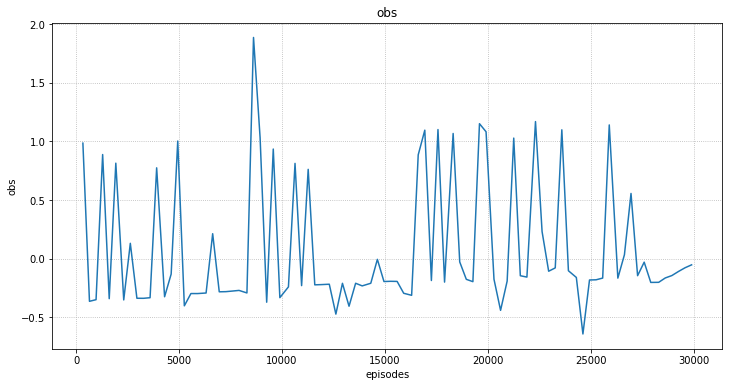

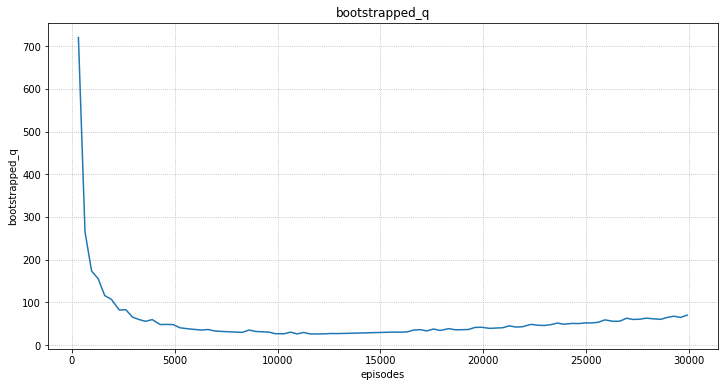

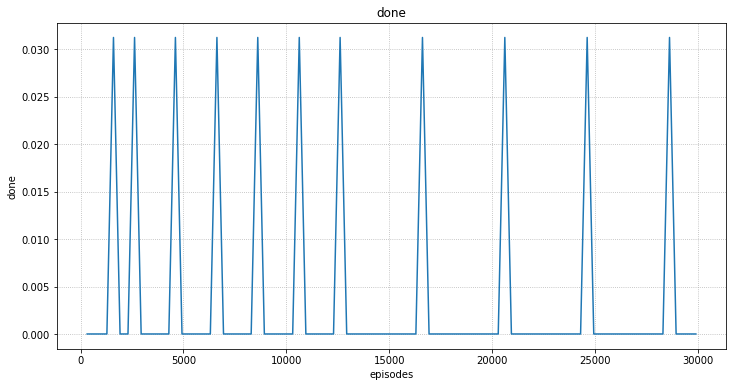

In [19]:
import matplotlib.pyplot as plt
for name in list(logs.keys())[1:]:
  plt.plot(logs['iterations'], logs[name])
  plt.title(name)
  plt.ylabel(name)
  plt.xlabel('episodes')
  plt.grid(ls=':')
  plt.show()

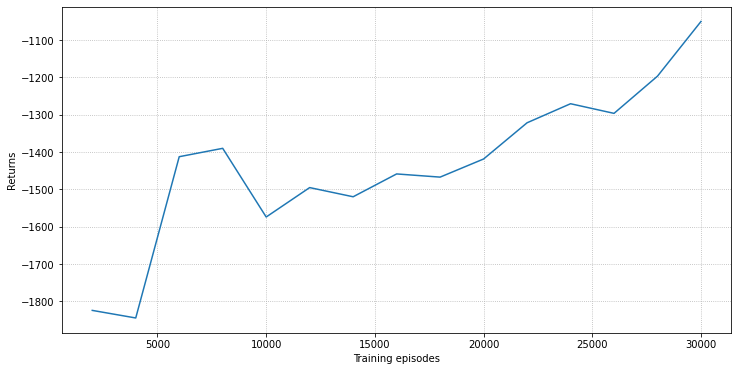

In [32]:
f = plt.figure()
plt.plot(return_ts, returns)
plt.xlabel('Training episodes')
plt.ylabel('Returns')
plt.grid(ls=':')
plt.show()
f.savefig('./results/figures/returns.png')

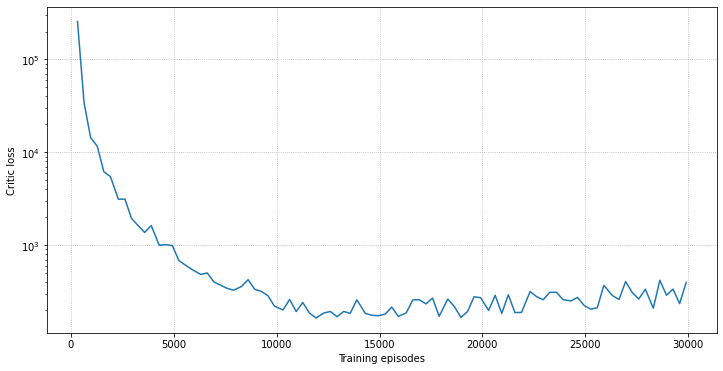

In [36]:
f = plt.figure()
plt.plot(logs['iterations'], logs['value_loss'])
plt.yscale('log')
plt.xlabel('Training episodes')
plt.ylabel('Critic loss')
plt.grid(ls=':')
plt.show()
f.savefig('./results/figures/critic_loss.png')

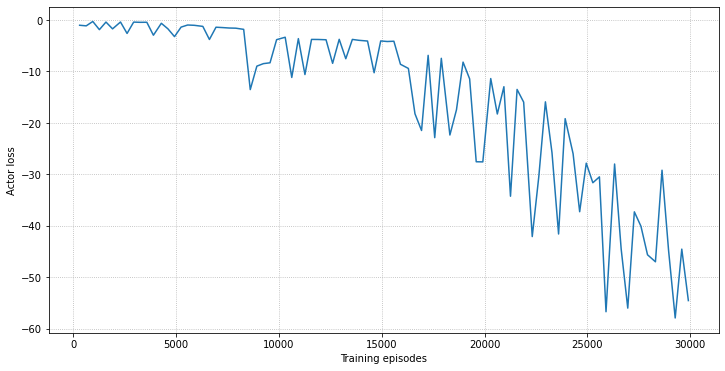

In [35]:
f = plt.figure()
plt.plot(logs['iterations'], logs['policy_loss'])
plt.xlabel('Training episodes')
plt.ylabel('Actor loss')
plt.grid(ls=':')
plt.show()
f.savefig('./results/figures/actor_loss.png')

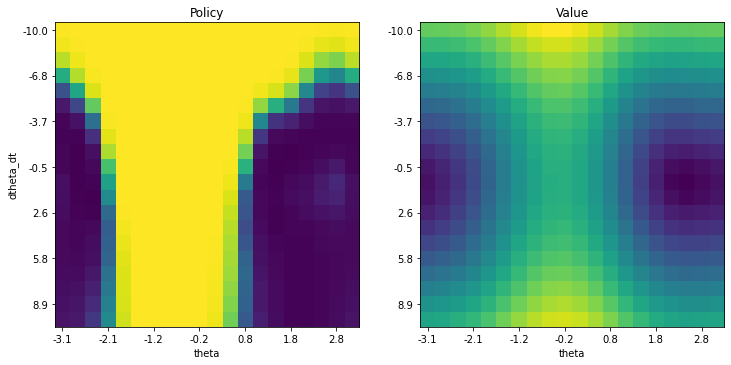

In [24]:
# final policy and value

plot_policy_on_pendulum(pendulum_agent, num_bins=20)